# 국민청원 데이터로 청원 카테고리 분류하기

* 청원의 카테고리를 분류해 봅니다.

In [2]:
# 필요한 모듈들을 불러옵니다.
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.23.4
1.16.4


In [5]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'



In [7]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(395547, 8)

In [8]:
# 전체 데이터 중 투표가 500건 이상인 데이터를 기준으로 가져옵니다.
df = petitions.loc[(petitions['votes'] > 500)].copy()
df.shape

(5388, 8)

In [9]:
category_count = df['category'].value_counts()
category_count

인권/성평등         699
육아/교육          606
안전/환경          526
교통/건축/국토       503
보건복지           492
정치개혁           466
기타             444
문화/예술/체육/언론    308
행정             264
외교/통일/국방       261
일자리            250
경제민주화          191
반려동물           160
미래              86
성장동력            52
저출산/고령화대책       44
농산어촌            36
Name: category, dtype: int64

In [14]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(377756, 8)

In [15]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [16]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000) & (petitions['votes'] < 100000)].copy()

# 수가 줄어들었음을 확인할 수 있습니다.
df.shape

(3235, 8)

In [17]:
# 카테고리별 국민청원 수를 확인 해 봅니다. 
category_count = df['category'].value_counts()
category_count

인권/성평등         422
육아/교육          389
안전/환경          318
보건복지           314
교통/건축/국토       288
정치개혁           264
기타             254
문화/예술/체육/언론    189
외교/통일/국방       156
일자리            151
행정             148
반려동물           111
경제민주화          107
미래              52
성장동력            28
저출산/고령화대책       26
농산어촌            18
Name: category, dtype: int64

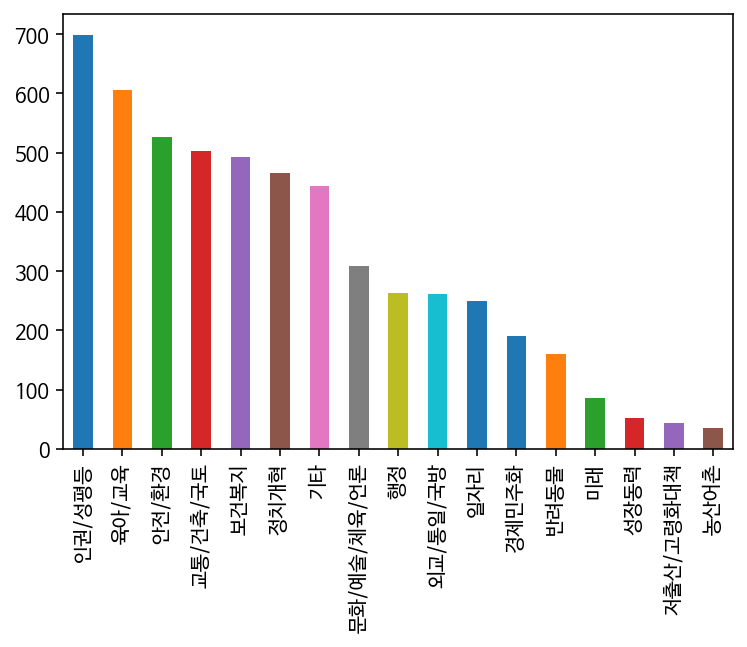

In [13]:
# 카테고리를 'bar' plot으로 시각화합니다.
%matplotlib inline 
plt.rcParams['font.family'] = "NanumBarunGothic"
category_count.plot(kind='bar')

In [14]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다. 카테고리에 해당되는 칼럼을 똑같이 복사해서 새로운 칼럼을 제작합니다.
df['category_pred'] = df['category'].copy()

In [15]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,기타
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리


In [16]:
# 첫 번째 인덱스를 샘플 데이터로 활용합니다. 
sample_index = df.iloc[0][0]
sample_index

28

In [17]:
sample_title = df['title'][sample_index]
sample_title

'치과위생사 국가고시 날짜 변경 억울합니다'

In [18]:
# 전처리 전 샘플 데이터 
sample_content = petitions['content'][sample_index]
sample_content

'안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생입니다. 다름이 아니라 너무 억울한\\n일이 생겨  이렇게 글을 적어봅니다. 저희 3학년들은 올해 아주 중요한 시험이  있었습니다.3년동안 힘들게 고생하여 이제곧\\n끝난다.조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을\\n보내주었습니다. 그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다.국시원에서 국가고시 날짜가 변경 되었다.\\n그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다. 그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의 2번 국시를 볼수없다\\n그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년 18년 1월 5일이다 라는것입니다.\\n그 말을  듣고 더욱 이해할수가 없었습니다. 먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도\\n없고 그공지글도 그냥 통보였습니다. 국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게\\n말이 됩니까? 고등학생들이 보는 모의고사,수능도 이런식으로  변경 하지않습니다.  통보로 날짜를 변경하는건  저희\\n에비 의료기사들을 무시하는걸로 보입니다. 저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다. 하지만 저는  그러지 못할꺼같습니다.  아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다.\\n17년 12월16일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다. 공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요? 먼저 그날의 시험을 보기로 한 학생들은 저희입니다\\n왜 갑자기 저희가 양보해야하고  피해를봐야합니까?  저희국시 앞으로 4달남은상

# 전처리 하기 

In [19]:
# 전처리를 진행하는 함수를 제작합니다. 전처리를 하는 이유는 결측치나 노이즈를 제거해줌으로써 온전한 예측을 진행하기 위해서입니다.
def preprocessing(text):
    # 우선 개행문자를 제거한다.
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    
    # 그 다음 한글, 영문만 남기고 모두 제거하도록 합니다. '가'부터 '힣'까지, 'ㅏ' 부터 'ㅣ' 까지, 대소문자 a부터 z까지만 남기고 제거합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [20]:
# 예측에 도움이 되지 않는 불용어를 제거하는 함수를 제작합니다.
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) # stops 가 담기지 않은 문장 내 토큰들은 제거합니다.

In [21]:
# 위 샘플데이터에 그대로 전처리 적용
pre_sample_content = preprocessing(sample_content)

In [22]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [23]:
pre_sample_content

'안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  치위생과  학년 학생입니다  다름이 아니라 너무 억울한 일이 생겨  이렇게 글을 적어봅니다  저희  학년들은 올해 아주 중요한 시험이  있었습니다  년동안 힘들게 고생하여 이제곧 끝난다 조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을 보내주었습니다  그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다 국시원에서 국가고시 날짜가 변경 되었다  그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다  그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의  번 국시를 볼수없다 그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년   년   일이다 라는것입니다  말을  듣고 더욱 이해할수가 없었습니다  먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도 없고 그공지글도 그냥 통보였습니다  국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게 말이 됩니까  고등학생들이 보는 모의고사 수능도 이런식으로  변경 하지않습니다   통보로 날짜를 변경하는건  저희 에비 의료기사들을 무시하는걸로 보입니다  저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다  하지만  그러지 못할꺼같습니다   아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다    년    일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들  공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요  먼저 그날의 시험을 보기로 학생들은 저희입니다 갑자기 저희가 양보해야하고  피해를봐야합니까   저희국시 앞으로  달남은상태였고 지금 학생들이 지쳐지만   월만 참으면 된다 라는 생각으로  견딘 학

In [24]:
# 해당 데이터를 전처리한 뒤 칼럼으로 추가합니다.
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

Wall time: 582 ms


In [25]:
# 해당 데이터의 불용어를 제거한 뒤 칼럼으로 추가합니다.
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

Wall time: 893 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [26]:
# 학습세트와 테스트세트를 7대 3으로 나누어줍니다.
df = df.reindex()

In [27]:
df.shape

(5388, 11)

In [28]:
split_count = int(df.shape[0] * 0.7) # 2264
split_count

3771

In [29]:
df_train = df[:split_count].copy() # 학습세트에 70%를 채워줍니다. 
df_train.shape

(3771, 11)

In [30]:
# 학습세트의 상위 5개 항목만 출력해봅니다. 
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,기타,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...


In [31]:
df_test = df[split_count:].copy() # 훈련세트에 나머지 30%를 채워줍니다. 
df_test.shape

(1617, 11)

In [32]:
# 테스트세트의 상위 5개 항목만 출력해봅니다. 
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
278676,361769,2018-08-31,2018-09-30,0,661,육아/교육,제아이를 착을수 있게 도와주세요. (국제아동탈취),Sensitive\nDear #############.\nI am #########...,육아/교육,Sensitive Dear I am ...,Sensitive Dear I am ...
278697,361808,2018-08-31,2018-09-30,0,922,보건복지,성매매 여성에게 2260만원 지원 조례를 폐기해 주세요,"성매매 여성에게 1인당 최대 2,260만원을 지원한다는 조례를 인천시가 제정중입니다...",보건복지,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...
278704,361818,2018-08-31,2018-09-30,0,646,농산어촌,일본 방사능 식품을 먹고 싶지 않습니다,저는 일본 방사능에 걱정을 갖고 있는 시민입니다.\n일본 원전 사태 이후로 일본 식...,농산어촌,저는 일본 방사능에 걱정을 갖고 있는 시민입니다 일본 원전 사태 이후로 일본 식품...,일본 방사능에 걱정을 갖고 시민입니다 일본 원전 사태 이후로 일본 식품은 물론 수...
278723,361861,2018-09-01,2018-10-01,0,1011,교통/건축/국토,사전 분양제도를 악용하는 악질 건설사 처벌을 청원합니다.,"포항 자이, 오포 양우, 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...",교통/건축/국토,포항 자이 오포 양우 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...,포항 자이 오포 양우 화성동탄 부영 최근 신축 아파트의 부실시공이 연일 언론을 ...
278822,361999,2018-09-01,2018-10-01,0,1215,안전/환경,부산 영도(구)해사고 해경특공대 훈련시설 반대합니다,부산 영도 (구)해사고 해경특공대 훈련시설 반대 청원\n남해지방해양경찰청은 부산 영...,안전/환경,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...


## 카테고리 

In [33]:
# 학습세트의 모습을 테스트세트의 카테고리, 그리고 해당 카테고리의 비율로 이루어진 데이터로 만듭니다.
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

,category_x,category_y
인권/성평등,486,0.128878
육아/교육,413,0.109520
정치개혁,373,0.098913
안전/환경,368,0.097587
보건복지,332,0.088040
기타,299,0.079289
교통/건축/국토,295,0.078229
문화/예술/체육/언론,236,0.062583
행정,196,0.051976
외교/통일/국방,184,0.048793


In [34]:
# 테스트세트의 모습을 위와 동일하게 제작합니다.
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)

,category_x,category_y
인권/성평등,213,0.131725
교통/건축/국토,208,0.128633
육아/교육,193,0.119357
보건복지,160,0.098949
안전/환경,158,0.097712
기타,145,0.089672
정치개혁,93,0.057514
외교/통일/국방,77,0.047619
일자리,73,0.045145
문화/예술/체육/언론,72,0.044527


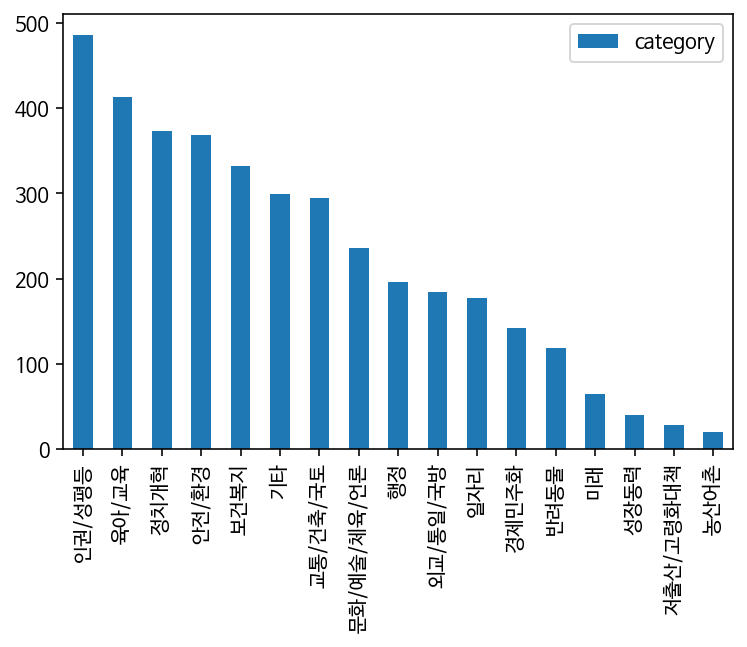

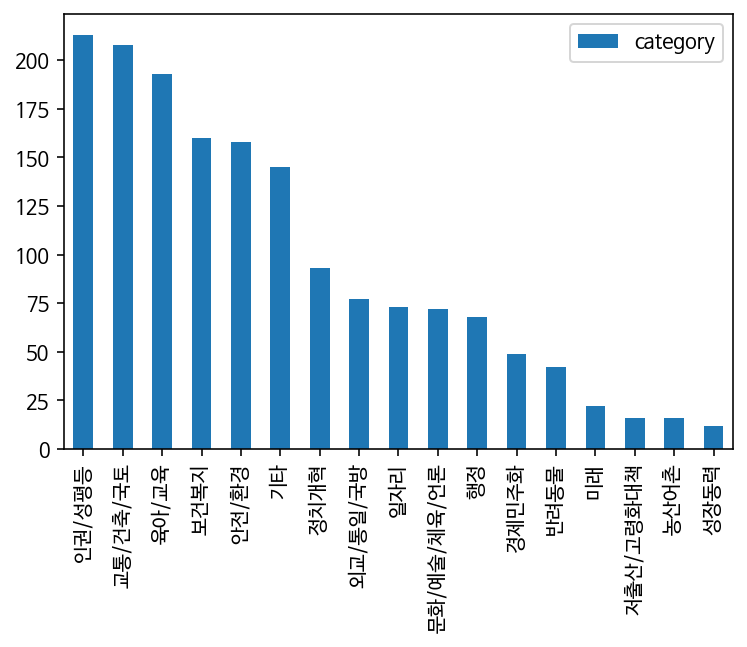

In [35]:
# 그리고 두 세트를 bar plot으로 출력합니다.
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [36]:
# 학습과 분류를 시키기 위해 먼저 벡터화를 하기로 합니다. 학습이나 분류 전에 텍스트는 컴퓨터가 알아먹을 수 없으므로 벡터화를 진행합니다. (vectorizer를 생성합니다.)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [37]:
%%time 
# 학습세트와 테스트세트를 CounterVectorizer를 이용해 벡터 정규화합니다(fit -> Transform). 정규화하는 이유는 Feature들 끼리 다른 스케일을 통일 시켜주는 역할을 합니다. 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

Wall time: 10.7 s


(3771, 2000)

In [38]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

Wall time: 5.84 s


(1617, 2000)

In [39]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'article',
 'articleview',
 'a는',
 'a의',
 'a형',
 'b형',
 'cctv',
 'cctv를',
 'cj']

In [40]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,article,articleview,a는,a의,a형,b형,cctv,cctv를,cj,...,후에도,훨씬,희망을,힘든,힘들게,힘들고,힘들어,힘없는,힘을,힘이
0,140,141,89,113,89,89,57,61,296,288,...,79,133,85,224,136,64,64,59,130,112


In [41]:
# 추가로 TF-IDF 를 이용해 벡터 정규화를 진행합니다. TF-IDF은 통계적 수치 중 하나인데, TF(단어 빈도수)와 IDF(역 - 문서 빈도수)를 곱한 값이다. 이 점수가 높은 단어일 수록 다른 문서에는 많지 않고 해당 문서에서 자주 등장하는 단어를 의미합니다. 반대로 단어의 중요도가 낮다는 것은 하나의 문서에서 많이 나오지 않고 다른 문서에서 자주 등장하는 단어라는 의미를 갖습니다.
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF로 가중치를 먹여 벡터를 정규화 합니다. (간단하게 한다)
transformer = TfidfTransformer(smooth_idf=False) # 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정합니다. 결국 이 코드에서는 그냥 생성하는 것으로 결정(False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [42]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

Wall time: 35 ms


(3771, 2000)

In [43]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

Wall time: 14 ms


(1617, 2000)

In [44]:
test_feature_tfidf.shape

(1617, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [45]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용해서 분류를 합니다. 
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2018, verbose=0,
                       warm_start=False)

In [46]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

Wall time: 1.79 s


# 학습이 잘 되었는지 평가하기

In [47]:
# 이제 학습이 잘 되었는 지를 확인합니다. 성능지표는 교차검증(cross-validation)을 통한 accuracy를 확인할 것입니다. 교차검증이란, 선택한 비율만큼 훈련세트와 테스트세트를 분할하여 표본을 만들어준 뒤, 이 표본을 교차하면서 검증하는 모델 평가 방법입니다.
# K-fold 교차검증이란, 데이터를 K개로 쪼개어 하나는 검증 데이터, 나머지(k-1)는 훈련 데이터로 사용되며 검증이 끝나면 검증 데이터를 쪼갠 다른 데이터로 교체 후 검증하는 것을 K번 반복하는 것입니다. 그리고 K번의 성능을 평균으로 구합니다.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
# cross_val_score 의 파라미터는 (모델명, 훈련데이터, 타겟, cv(k-flod), options)입니다.
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 8.01 s


array([0.42384106, 0.41246684, 0.38461538, 0.40981432, 0.38196286])

In [48]:
# 성능지표를 평균으로 뽑고 이를 백분율로 나오게끔 수치를 뽑아봅니다.
round(np.mean(score)*100,2)
# 높지 않은 성능지표가 나왔습니다. 

40.25

# 예측

In [49]:
# 고찰하기 위해 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['일자리', '교통/건축/국토', '기타'], dtype=object)

In [50]:
y_pred.shape

(1617,)

In [51]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,일자리
1,교통/건축/국토
2,기타
3,교통/건축/국토
4,교통/건축/국토


In [52]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

육아/교육          378
인권/성평등         274
정치개혁           182
보건복지           180
안전/환경          155
교통/건축/국토       142
반려동물            90
기타              72
경제민주화           49
일자리             29
문화/예술/체육/언론     29
외교/통일/국방        28
행정               8
저출산/고령화대책        1
Name: category_pred, dtype: int64

In [53]:
# 테스트 데이터에 위에 예측한 값을 칼럼으로 추가하고, 예측값과 같으면 1, 다르면 0을 나타내는 칼럼을 또 하나 추가합니다.
df_test['category_pred'] = y_pred

In [54]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
278676,361769,2018-08-31,2018-09-30,0,661,육아/교육,제아이를 착을수 있게 도와주세요. (국제아동탈취),Sensitive\nDear #############.\nI am #########...,일자리,Sensitive Dear I am ...,Sensitive Dear I am ...,0
278697,361808,2018-08-31,2018-09-30,0,922,보건복지,성매매 여성에게 2260만원 지원 조례를 폐기해 주세요,"성매매 여성에게 1인당 최대 2,260만원을 지원한다는 조례를 인천시가 제정중입니다...",교통/건축/국토,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...,0
278704,361818,2018-08-31,2018-09-30,0,646,농산어촌,일본 방사능 식품을 먹고 싶지 않습니다,저는 일본 방사능에 걱정을 갖고 있는 시민입니다.\n일본 원전 사태 이후로 일본 식...,기타,저는 일본 방사능에 걱정을 갖고 있는 시민입니다 일본 원전 사태 이후로 일본 식품...,일본 방사능에 걱정을 갖고 시민입니다 일본 원전 사태 이후로 일본 식품은 물론 수...,0
278723,361861,2018-09-01,2018-10-01,0,1011,교통/건축/국토,사전 분양제도를 악용하는 악질 건설사 처벌을 청원합니다.,"포항 자이, 오포 양우, 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...",교통/건축/국토,포항 자이 오포 양우 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...,포항 자이 오포 양우 화성동탄 부영 최근 신축 아파트의 부실시공이 연일 언론을 ...,1
278822,361999,2018-09-01,2018-10-01,0,1215,안전/환경,부산 영도(구)해사고 해경특공대 훈련시설 반대합니다,부산 영도 (구)해사고 해경특공대 훈련시설 반대 청원\n남해지방해양경찰청은 부산 영...,교통/건축/국토,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...,0


In [55]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기해서 확인을 해봅니다. 
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    1370
1     247
Name: pred_diff, dtype: int64

In [56]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 1617건의 데이터 중 247건 예측


In [57]:
# 예측이 성공한 비율을 확인해봅니다.
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 15.275200989486704


In [58]:
# 예측이 된 것과 안 된 것을 비교하기 위해 먼저 제대로 예측한 카테고리 데이터와 예측이 안 된 데이터를 변수로 만들어 담습니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
278723,361861,2018-09-01,2018-10-01,0,1011,교통/건축/국토,사전 분양제도를 악용하는 악질 건설사 처벌을 청원합니다.,"포항 자이, 오포 양우, 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...",교통/건축/국토,포항 자이 오포 양우 화성동탄 부영 등 최근 신축 아파트의 부실시공이 연일 언론...,포항 자이 오포 양우 화성동탄 부영 최근 신축 아파트의 부실시공이 연일 언론을 ...,1
279705,363136,2018-09-02,2018-10-02,0,7036,인권/성평등,성매매 피해자 여성 지원금 반대합니다.,안녕하세요. 저는 평범한 직장에 다니고있는 20대 남성입니다. 얼마전에 뉴스기사를 ...,인권/성평등,안녕하세요 저는 평범한 직장에 다니고있는 대 남성입니다 얼마전에 뉴스기사를 ...,안녕하세요 평범한 직장에 다니고있는 대 남성입니다 얼마전에 뉴스기사를 보고 ...,1
281476,365511,2018-09-04,2018-10-04,0,2203,인권/성평등,양성평등 징병제를 청원합니다.,남성이 당하는 성차별에 대해서는 사회적으로 둔감한 경향이 있습니다.\n대한민국에서 ...,인권/성평등,남성이 당하는 성차별에 대해서는 사회적으로 둔감한 경향이 있습니다 대한민국에서 현...,남성이 당하는 성차별에 대해서는 사회적으로 둔감한 경향이 대한민국에서 현재 남성들...,1
281763,365887,2018-09-04,2018-10-04,0,734,육아/교육,고등학교 교사와 자녀가 같은 학교에 있는(있었던)경우 내신과 대학입시가 공정했는지...,현재 고등학교 교사 자녀와 쌍둥이 자녀가 같은 학교에 있으면서 내신의 공정성이 의심...,육아/교육,현재 고등학교 교사 자녀와 쌍둥이 자녀가 같은 학교에 있으면서 내신의 공정성이 의심...,현재 고등학교 교사 자녀와 쌍둥이 자녀가 학교에 있으면서 내신의 공정성이 의심되는 ...,1
282396,366704,2018-09-05,2018-10-05,0,627,육아/교육,교육청 ‘분당 단가’를 현실화 시켜주세요,교육청에서 정하는 과목별 ‘분당단가’를 현실에 맞게 고쳐주세요.\n저는 아동미술 교...,육아/교육,교육청에서 정하는 과목별 분당단가 를 현실에 맞게 고쳐주세요 저는 아동미술 교습...,교육청에서 정하는 과목별 분당단가 를 현실에 맞게 고쳐주세요 아동미술 교습소를 ...,1


In [59]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
278676,361769,2018-08-31,2018-09-30,0,661,육아/교육,제아이를 착을수 있게 도와주세요. (국제아동탈취),Sensitive\nDear #############.\nI am #########...,일자리,Sensitive Dear I am ...,Sensitive Dear I am ...,0
278697,361808,2018-08-31,2018-09-30,0,922,보건복지,성매매 여성에게 2260만원 지원 조례를 폐기해 주세요,"성매매 여성에게 1인당 최대 2,260만원을 지원한다는 조례를 인천시가 제정중입니다...",교통/건축/국토,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...,성매매 여성에게 인당 최대 만원을 지원한다는 조례를 인천시가 제정중입니다...,0
278704,361818,2018-08-31,2018-09-30,0,646,농산어촌,일본 방사능 식품을 먹고 싶지 않습니다,저는 일본 방사능에 걱정을 갖고 있는 시민입니다.\n일본 원전 사태 이후로 일본 식...,기타,저는 일본 방사능에 걱정을 갖고 있는 시민입니다 일본 원전 사태 이후로 일본 식품...,일본 방사능에 걱정을 갖고 시민입니다 일본 원전 사태 이후로 일본 식품은 물론 수...,0
278822,361999,2018-09-01,2018-10-01,0,1215,안전/환경,부산 영도(구)해사고 해경특공대 훈련시설 반대합니다,부산 영도 (구)해사고 해경특공대 훈련시설 반대 청원\n남해지방해양경찰청은 부산 영...,교통/건축/국토,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...,부산 영도 구 해사고 해경특공대 훈련시설 반대 청원 남해지방해양경찰청은 부산 영도...,0
278978,362185,2018-09-01,2018-10-01,0,593,경제민주화,삼성바이오로직스 회계 사기 수사해 주십시오.,삼성바이오로직스 기업 가치평가 회계 사기 꼭 수사해 주십시오.\n말도 안되는 근거조...,정치개혁,삼성바이오로직스 기업 가치평가 회계 사기 꼭 수사해 주십시오 말도 안되는 근거조작...,삼성바이오로직스 기업 가치평가 회계 사기 꼭 수사해 주십시오 말도 안되는 근거조작...,0


In [60]:
# 항목 당 잘못 예측된 경우를 찾아봅니다.
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

교통/건축/국토       181
인권/성평등         154
안전/환경          139
기타             136
보건복지           131
육아/교육          113
정치개혁            80
외교/통일/국방        73
일자리             71
문화/예술/체육/언론     71
행정              67
경제민주화           46
반려동물            42
미래              22
저출산/고령화대책       16
농산어촌            16
성장동력            12
Name: category, dtype: int64

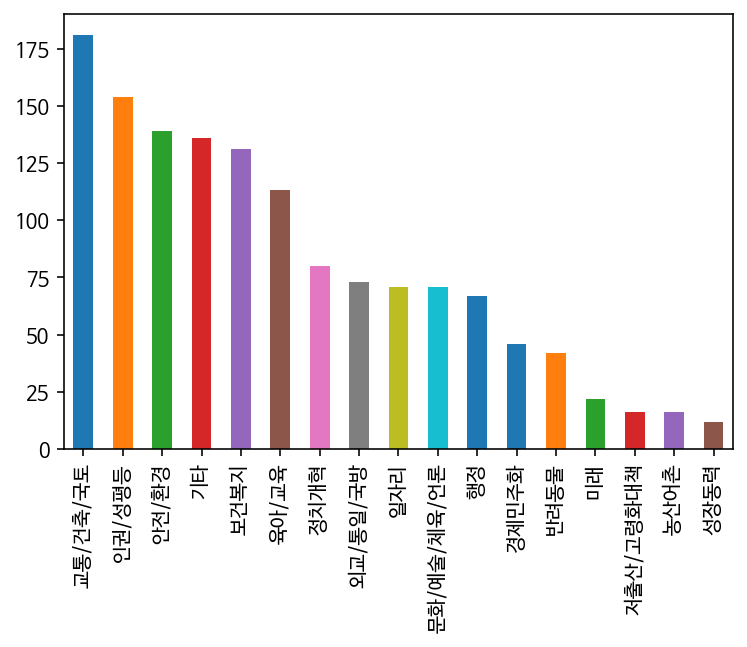

In [61]:
# 잘못 예측한 데이터를 bar-plot으로 뽑아보면 교통/건축/국토 항목이 제일 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [62]:

predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
278676,육아/교육,일자리,제아이를 착을수 있게 도와주세요. (국제아동탈취),Sensitive\nDear #############.\nI am #########...
278697,보건복지,교통/건축/국토,성매매 여성에게 2260만원 지원 조례를 폐기해 주세요,"성매매 여성에게 1인당 최대 2,260만원을 지원한다는 조례를 인천시가 제정중입니다..."
278704,농산어촌,기타,일본 방사능 식품을 먹고 싶지 않습니다,저는 일본 방사능에 걱정을 갖고 있는 시민입니다.\n일본 원전 사태 이후로 일본 식...
278822,안전/환경,교통/건축/국토,부산 영도(구)해사고 해경특공대 훈련시설 반대합니다,부산 영도 (구)해사고 해경특공대 훈련시설 반대 청원\n남해지방해양경찰청은 부산 영...
278978,경제민주화,정치개혁,삼성바이오로직스 회계 사기 수사해 주십시오.,삼성바이오로직스 기업 가치평가 회계 사기 꼭 수사해 주십시오.\n말도 안되는 근거조...
279111,외교/통일/국방,인권/성평등,진선미 여성가족부 장관 지명자 철회를 청원합니다.,[ 진선미 여성가족부 장관 지명자 철회를 촉구하며 ]\n군동성애 허용을 주장하는 진...
279121,인권/성평등,육아/교육,대통령할아버지! 국립 인천 해사고 3학년 해기사 실습생의 한을 풀어주세여!,대통령 할아버지께\n저는 국립 인천해사고 3학년 학생입니다. 좋은 선장이 되겠다는 ...
279248,문화/예술/체육/언론,정치개혁,김대용 축구국제심판 박탈하라,"베트남과 아랍에미리트 아시안게임의 3,4위전에서 보인 오심의 정도는 정말 축구의 기..."
279252,행정,경제민주화,무책임한 119 대원들을고발합니다.,2018년 8월 29일 제 동생이 병원 입원을 하러 가야 했습니다. 제 동생의 병명...
279284,문화/예술/체육/언론,육아/교육,오지환 선수의 군면제 특혜 철회와 앞으로 아시안게임의 프로선수 차출금지를 요구합니다,오늘 9월 1일 자카르타 아시안게임에서 대한민국이 일본을 상대로 승리하면서 야구 국...


In [63]:
# 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 확인합니다. 
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

# 밑을 보면 기타로 분류되었지만 사실상 예측된 카테고리 분류는 다른 쪽으로 된 것을 확인할 수 있습니다. 

,category,category_pred,title,content
279819,기타,인권/성평등,전통적 가정제도 부정하는 진선미 의원의 여가부 장관 지명 철회를 청원합니다,"대한민국에서 보편적인 혼인, 가족관으로 두 자녀를 키우고 있는 국민입니다. 그런데,..."
279982,기타,정치개혁,스포츠토토(베트맨) 국민 피 빨아먹는 짓 중단하게 해주세요,현재 한국의 스포츠토토는 10년이 훌쩍 지난 것으로 알고 있습니다. 하지만 최근에 ...
282811,기타,인권/성평등,주택임대사업자에 대한 지원정책 폐지후 보유세(종부세)를 강화하여야 합니다.,주택임대사업자 세제지원 정책을 폐지 한 후에 종부세를 강화하여야 종부세 강화의 실효...
284420,기타,경제민주화,도시공원해제 헌법재판소 판결을 따르라,도시공원은 세금은 꼬바꼬박 내면서도 개인의 재산권을 행사하지 못하게 국가에서 묶어 ...
287152,기타,인권/성평등,9.17 -18 인천 아시아드 신천지행사를 불허해주십시요,9월17~18일에 인천아시아드 경기장에서 평화행사를 빙자한 반사회적 단체인 신천지의...
287766,기타,반려동물,대대적인 사기극에 휘말린것 같습니다.,대대적익 사기극에 휘말린거같아 민원드립니다.\n피해 본사람만해도 수백명입니다.\n리...
288502,기타,보건복지,의료사고로피눈물을흘리는사연들주세요,진 정 서\n수 신 : 문재인 대통령님\n참 조 : 비서실장님\n발 신 : ...
289043,기타,육아/교육,친애하는 대통령님께 꼭한번 봐주세요,조카는 이제 겨우 22살 이에여\n요번에 8월 27일날 군대에 입대 해서 9월10일...
289388,기타,외교/통일/국방,유투버 이환의 유튜브활동을 금지해주세요.,온갖 잘못을 저지르고도 반성하기는 커녕 당당히 영상을 올리는 추악한 이환의 유투버 ...
289705,기타,정치개혁,대한민국 언론의 직무유기를 처벌해주세요!,9월 10일 월요일\n조코 위도도 인도네시아 대통령님이 방한하셨습니다\n그러나 이에...
